<a href="https://colab.research.google.com/github/ellison-ja/githubtest/blob/main/cluster_stoinks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
pip install yfinance

In [120]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import UpSampling1D
from keras.layers import Dropout
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import random

In [121]:
stoinks = pd.read_csv('/content/drive/MyDrive/nyse-listed_csv.csv')
ticker_list=stoinks['ACT Symbol'].to_list()
stoinks.head()

,ACT Symbol,Company Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Inc. Common Stock
2,AA$B,Alcoa Inc. Depository Shares Representing 1/10...
3,AAC,"AAC Holdings, Inc. Common Stock"
4,AAN,"Aaron's, Inc. Common Stock"


In [122]:
# t = yf.Ticker('TSLA')
# t.info

In [123]:
rand_tick=ticker_list.copy()
random.shuffle(rand_tick)
sub_stoink=rand_tick[:1000]

In [124]:
X =pd.DataFrame(columns=['ticker','marketCap','averageDailyVolume10Day','twoHundredDayAverage','enterpriseToRevenue','heldPercentInstitutions','trailingPE','priceToSalesTrailing12Months','fiftyDayAverage','profitMargins'])
for corp in sub_stoink:
  print(corp)
  tick = yf.Ticker(corp)
  try:
    inf=tick.info
    mc = inf['marketCap']
    dv = inf['averageDailyVolume10Day']
    da = inf['twoHundredDayAverage']
    rev = inf['enterpriseToRevenue']
    inst = inf['heldPercentInstitutions']
    pe = inf['trailingPE']
    pts = inf['priceToSalesTrailing12Months']
    avg = inf['fiftyDayAverage']
    pmarg = inf['profitMargins']

  except:
    continue
  if np.NaN not in ([mc,dv,da,rev,inst,pe,pts,avg,pmarg]) and None not in([mc,dv,da,rev,inst,pe,pts,avg,pmarg]):
    print([mc,dv,da,rev,inst,pe,pts,avg,pmarg])
    x = pd.DataFrame([[corp,mc,dv,da,rev,inst,pe,pts,avg,pmarg]], columns=['ticker','marketCap','averageDailyVolume10Day','twoHundredDayAverage','enterpriseToRevenue','heldPercentInstitutions','trailingPE','priceToSalesTrailing12Months','fiftyDayAverage','profitMargins'])
  else:
    continue
  X= X.append(x,  ignore_index=False, verify_integrity=False, sort=False)


JTD
ALK
PCP
BMO
ASB
[2966392832, 1097300, 14.751655, 4.477, 0.76936996, 9.521932, 2.6461835, 17.803333, 0.27366]
DLB
[9490918400, 318371, 77.34108, 7.248, 0.92967004, 41.79111, 8.169207, 93.91333, 0.19914]
MYI
[965013952, 117657, 13.686546, 26.42, 0.33791, 18.73016, 16.367882, 14.154546, 0.87428004]
STK
GWB
STRI
AIR
CAF
CBT
CDE
HLX
[677226112, 2178971, 3.6126618, 1.267, 0.88523, 29.096775, 0.9097525, 4.408485, 0.03501]
JNPR
[8256589824, 4891571, 22.898417, 1.869, 0.96262, 21.22034, 1.8635375, 22.99909, 0.08924]
SCHW
[109738270720, 9457742, 42.003094, 5.693, 0.70383, 27.547173, 9.3865595, 54.31515, 0.28218]
AFM
BHLB
CBS.A
FT
SB
VSH
[3350279168, 989514, 17.755684, 1.285, 0.95021003, 33.760933, 1.3706526, 21.157879, 0.04063]
RSG
[30087639040, 1059071, 92.78885, 3.823, 0.93574, 29.583204, 2.9622273, 95.19334, 0.100530006]
BK
[37182017536, 6162857, 38.096546, -6.899, 0.85067004, 10.947781, 2.403181, 42.38, 0.23378]
PL
LUX
ALU
HOG
[6338086912, 1481542, 31.678633, 3.427, 0.96023005, 57.034477

In [129]:
X.to_csv("/content/drive/MyDrive/stoink/stock_features_clean.csv", header=['ticker','marketCap','averageDailyVolume10Day','twoHundredDayAverage','enterpriseToRevenue','heldPercentInstitutions','trailingPE','priceToSalesTrailing12Months','fiftyDayAverage','profitMargins'], index=False) 
# building the data took a while...save as csv with header so we can access later

In [147]:
an = pd.read_csv("/content/drive/MyDrive/stoink/stock_features_clean.csv")

In [148]:
an.tail()

,ticker,marketCap,averageDailyVolume10Day,twoHundredDayAverage,enterpriseToRevenue,heldPercentInstitutions,trailingPE,priceToSalesTrailing12Months,fiftyDayAverage,profitMargins
311,MTX,2261620736,103614,55.843742,1.832,0.99549,20.732315,1.410692,64.044240,0.06880
312,GEO,1014193344,3746028,10.185395,1.569,0.66214,7.206896,0.423694,9.074848,0.05814
313,UPS,137430646784,3255100,158.456620,1.955,0.69480,30.157438,1.711465,165.870600,0.05708
314,SEM,3827269376,476328,22.195827,1.539,0.77900,17.850409,0.702792,27.608181,0.03926
315,HRB,3059412224,2656728,16.054316,1.568,0.97489,16.320940,0.984957,16.104242,0.06383


In [149]:
Xdata = an.to_numpy()
Xdata=Xdata[:,1:]
Xdata = np.asarray(Xdata,dtype=np.float32)
np.shape(Xdata)

(316, 9)

In [162]:
#normalize data for PCA
Xnorm=Xdata/Xdata.max(axis=0)

In [166]:
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA

ipca = PCA(n_components=3)
ipca.fit(Xnorm)
Xt = ipca.transform(Xnorm)

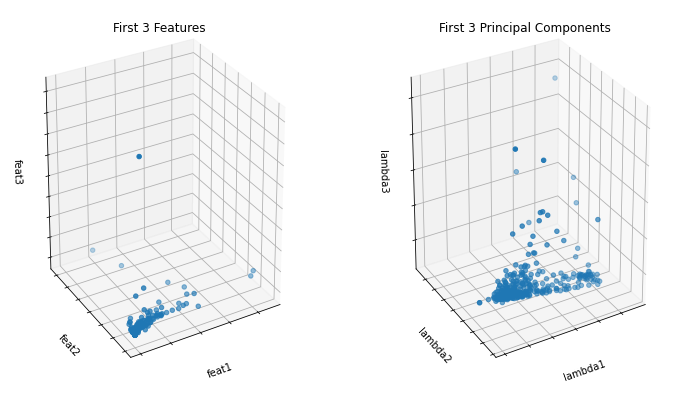

In [186]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(121,projection='3d')
ax.dist = 11
ax.view_init(elev=25., azim=240)
ax.set_xlabel('feat1')
ax.set_ylabel('feat2')
ax.set_zlabel('feat3')
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticklabels([])
ax.scatter3D(Xdata[:,0],Xdata[:,1],Xdata[:,2]);
ax.set_title('First 3 Features')
ax1 = fig.add_subplot(122,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)
ax1.set_xlabel('lambda1')
ax1.set_ylabel('lambda2')
ax1.set_zlabel('lambda3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xt[:,0],Xt[:,1],Xt[:,2]);
ax1.set_title('First 3 Principal Components');

Fit GMM and Kmeans for raw data

In [246]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
klabels = kmeans.fit(Xdata).predict(Xdata)

In [247]:
import sklearn as sk
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4, reg_covar=1e-6).fit(Xdata)
glabels = gmm.predict(Xdata)

Now fit GMM and Kmeans on PC's



In [248]:
kmeans_PCA = KMeans(4, random_state=0)
klabels_PCA = kmeans_PCA.fit(Xt).predict(Xt)

In [249]:
gmm_PCA = mixture.GaussianMixture(n_components=4,reg_covar=1e-6).fit(Xt)
glabels_PCA = gmm_PCA.predict(Xt)

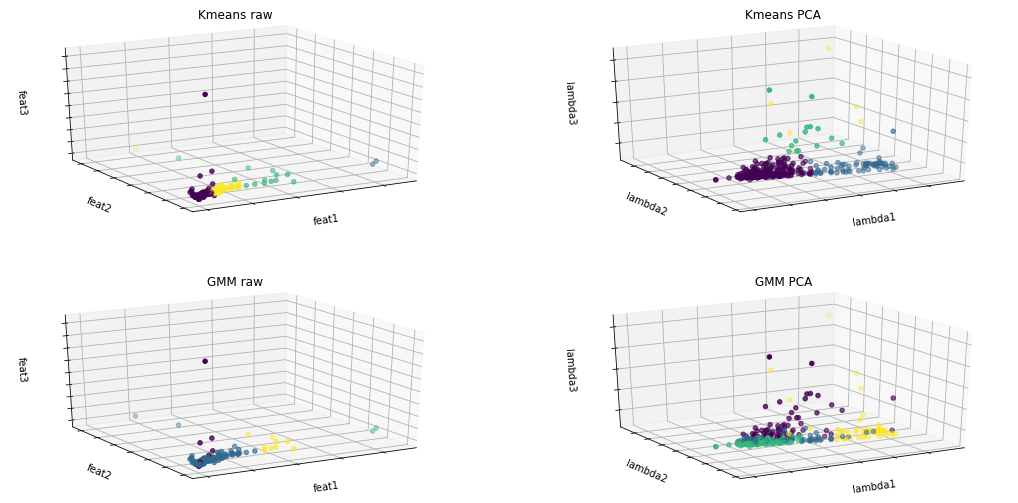

In [250]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(221,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)
ax1.set_xlabel('feat1')
ax1.set_ylabel('feat2')
ax1.set_zlabel('feat3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xdata[:,0],Xdata[:,1],Xdata[:,2],c=klabels);
ax1.set_title('Kmeans raw')
ax1 = fig.add_subplot(222,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)

ax1.set_xlabel('lambda1')
ax1.set_ylabel('lambda2')
ax1.set_zlabel('lambda3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xt[:,0],Xt[:,1],Xt[:,2],c=klabels_PCA);
ax1.set_title('Kmeans PCA')
ax1 = fig.add_subplot(223,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)

ax1.set_xlabel('feat1')
ax1.set_ylabel('feat2')
ax1.set_zlabel('feat3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xdata[:,0],Xdata[:,1],Xdata[:,2],c=glabels);
ax1.set_title('GMM raw')
ax1 = fig.add_subplot(224,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)

ax1.set_xlabel('lambda1')
ax1.set_ylabel('lambda2')
ax1.set_zlabel('lambda3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xt[:,0],Xt[:,1],Xt[:,2],c=glabels_PCA);
ax1.set_title('GMM PCA');

In [ ]:
# for i in range(len(an['ticker'].to_list())):
#   print(an['ticker'].to_list()[i], 'class: ', glabels_PCA[i])

In [427]:
Y=[]
Y1=[]
for corp in an['ticker'].to_list():
    print(corp)
    hist = yf.download(tickers=corp, interval="1d", start='2020-01-01', end='2021-01-22')
    prices = hist.loc[:,'Close'].values
    # vol = hist.loc[:,'Volume'].values


    #----optional trim data
    idx=len(prices) - 100
    prices=prices[idx:]
    if len(prices)<100:
      prices = np.pad(prices,(100-len(prices),0),'edge',)
    #vol=vol[idx:]

    
    #----optional normalize data
    nprices = [price/prices[0] for price in (prices)]
    #nvol = [v/vol[0] for v in (vol)]
    

    #find % growth over Y time period
    p_growth = ((prices[-1]-prices[0])/prices[0])
    

    #print(len(nvol))
    print(len(prices))
    
    Y.append(p_growth)
    Y1.append(nprices)

print('shape %Growth: ',np.shape(Y),'shape time series: ',np.shape(Y1))


ASB
[*********************100%***********************]  1 of 1 completed
100
DLB
[*********************100%***********************]  1 of 1 completed
100
MYI
[*********************100%***********************]  1 of 1 completed
100
HLX
[*********************100%***********************]  1 of 1 completed
100
JNPR
[*********************100%***********************]  1 of 1 completed
100
SCHW
[*********************100%***********************]  1 of 1 completed
100
VSH
[*********************100%***********************]  1 of 1 completed
100
RSG
[*********************100%***********************]  1 of 1 completed
100
BK
[*********************100%***********************]  1 of 1 completed
100
HOG
[*********************100%***********************]  1 of 1 completed
100
KW
[*********************100%***********************]  1 of 1 completed
100
BBF
[*********************100%***********************]  1 of 1 completed
100
VPV
[*********************100%***********************]  1 of 1 completed
100

In [373]:
#check if time series are incorrect dims
for i in range(len(Y1)):
  if len(Y1[i]) != 100:
    print(an['ticker'].to_list()[i])
    print(len(Y1[i]))

In [428]:
#assign classes based on percent growth
Ylabels=[]
for i in Y:
  if i < -0.001:
    group = 0
  elif  -.001< i <=.08:
    group = 1
  elif .08< i <=.28:
    group = 2
  elif i >.28:
    group = 3
  # elif i <=.1:
  #   group = 4
  Ylabels.append(group)

In [429]:

Y0=[]
[Y0.append(i==0) for i in Ylabels]
Y1_=[]
[Y1_.append(i==1) for i in Ylabels]
Y2=[]
[Y2.append(i==2) for i in Ylabels]
Y3=[]
[Y3.append(i==3) for i in Ylabels]
np.sum(Y0),np.sum(Y1_),np.sum(Y2),np.sum(Y3)

(55, 72, 105, 84)

(array([ 55.,   0.,   0.,  72.,   0.,   0., 105.,   0.,   0.,  84.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

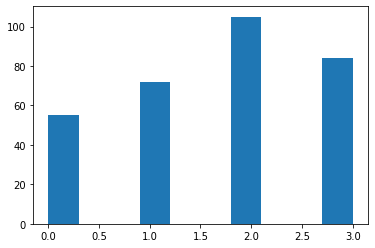

In [430]:
plt.subplot(111)
plt.hist(Ylabels)

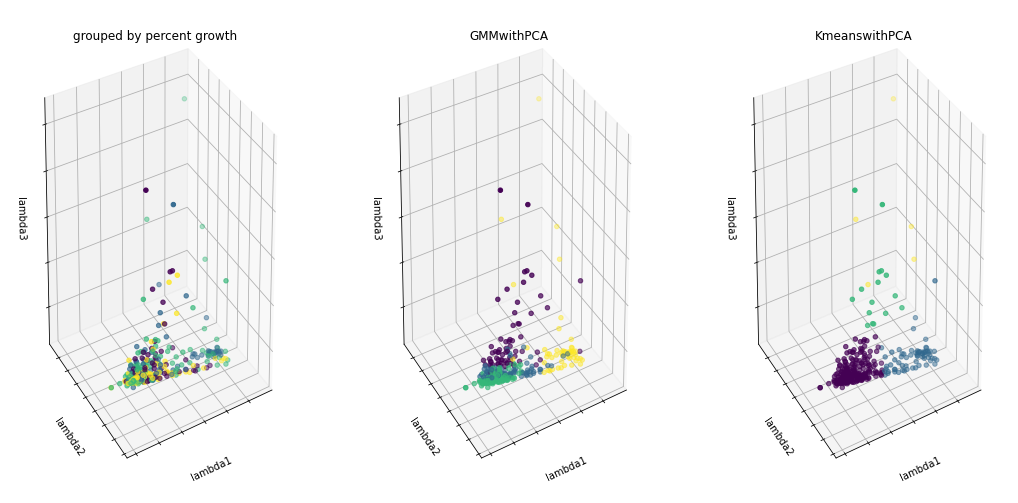

In [431]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(131,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)
ax1.set_xlabel('lambda1')
ax1.set_ylabel('lambda2')
ax1.set_zlabel('lambda3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xt[:,0],Xt[:,1],Xt[:,2],c=Ylabels);
ax1.set_title('grouped by percent growth');
ax1 = fig.add_subplot(132,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)
ax1.set_xlabel('lambda1')
ax1.set_ylabel('lambda2')
ax1.set_zlabel('lambda3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xt[:,0],Xt[:,1],Xt[:,2],c=glabels_PCA);
ax1.set_title('GMMwithPCA');
ax1 = fig.add_subplot(133,projection='3d')
ax1.dist = 11
ax1.view_init(elev=25., azim=240)
ax1.set_xlabel('lambda1')
ax1.set_ylabel('lambda2')
ax1.set_zlabel('lambda3')
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_xticklabels([])
ax1.scatter3D(Xt[:,0],Xt[:,1],Xt[:,2],c=klabels_PCA);
ax1.set_title('KmeanswithPCA');

It looks like these 9 features that were selected are not super great indicators of the raw percent growth of a compy in the last ~2 months. Lets visualize the time series to see if clustering base on these features can group trends in the time series. 

Text(0.5, 1.0, 'previous 30 days stock prices')

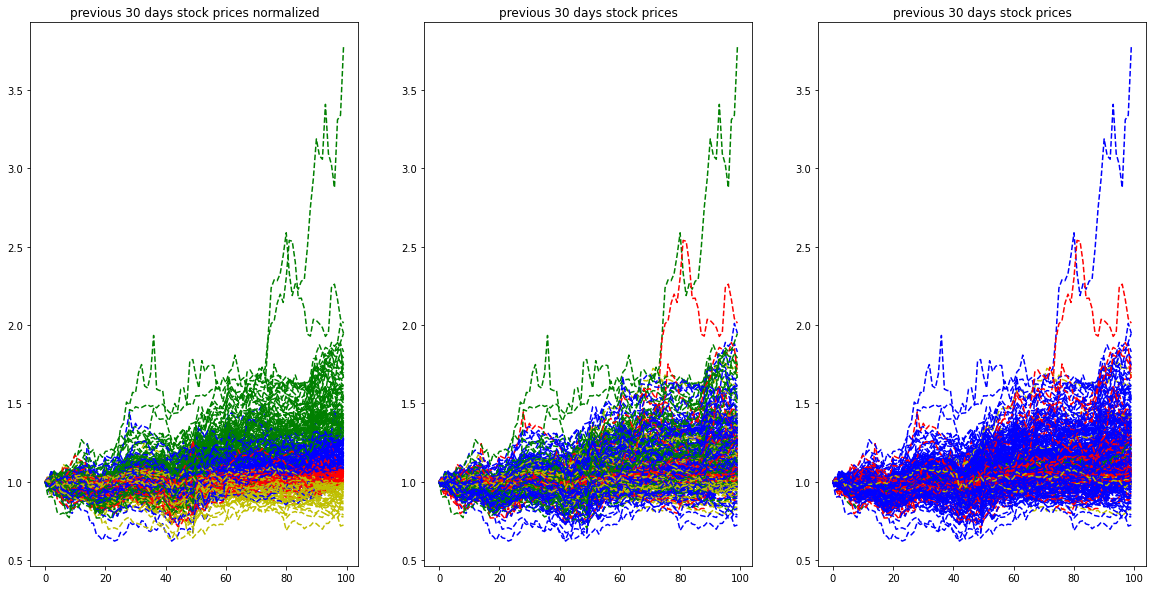

In [443]:
plt.figure(figsize=(20,10))
plt.subplot(131)
for i in range(0,len(Y1)):
  if Ylabels[i]==0:
    c='--y'
  elif Ylabels[i]==1:
    c='--r'
  elif Ylabels[i]==2:
    c='--b'
  elif Ylabels[i]==3:
    c='--g'
  plt.plot(Y1[i],c)
plt.title('previous 30 days stock prices normalized')
# plt.legend(an['ticker'].to_list())

plt.subplot(132)
for i in range(0,len(Y1)):
  if glabels_PCA[i]==0:
    c='--y'
  elif glabels_PCA[i]==1:
    c='--g'
  elif glabels_PCA[i]==2:
    c='--b'
  elif glabels_PCA[i]==3:
    c='--r'
  plt.plot(Y1[i],c)
plt.title('previous 30 days stock prices')
# plt.legend(an['ticker'].to_list())

plt.subplot(133)
for i in range(0,len(Y1)):
  if klabels_PCA[i]==0:
    c='--b'
  elif klabels_PCA[i]==1:
    c='--r'
  elif klabels_PCA[i]==2:
    c='--y'
  elif klabels_PCA[i]==3:
    c='--g'
  plt.plot(Y1[i],c)
plt.title('previous 30 days stock prices')
# plt.legend(an['ticker'].to_list())
# print('future month growth in percent PLTR: ', (ny[0][-1][0] - ny[0][0][0] )/ ny[0][0][0])
# print('future month growth in percent all: ', (ny[:,-1,0] - ny[:,0,0] )/ ny[:,0,0])

In [433]:
np.shape(Y)

(316,)

In [434]:
import sklearn
print(sklearn.metrics.confusion_matrix(Ylabels, glabels_PCA))
print('accuracy: ', sklearn.metrics.accuracy_score(Ylabels, glabels_PCA))

[[18 10 22  5]
 [14 18 15 25]
 [24 19 44 18]
 [10 24 44  6]]
accuracy:  0.2721518987341772


In [435]:
import sklearn
print(sklearn.metrics.confusion_matrix(Ylabels, klabels_PCA))
print('accuracy: ', sklearn.metrics.accuracy_score(Ylabels, klabels_PCA))

[[40  9  6  0]
 [42 25  4  1]
 [75 24  2  4]
 [71  9  4  0]]
accuracy:  0.2120253164556962


Overall there features were not good predictors of the percent growth for the last 100 trading days. However, from the time series plots, it is clear that GMM got beter seperation of classes, and was closer to classifying the patterns of stocks than Kmeans. The power of both clustering methods in identifying %growth could greatly benefit from more thorough feature selection as well as including a greater number of features. 

In [125]:
# d = np.asarray(x,dtype=np.float32)

In [126]:
# df = pd.DataFrame(d, columns =['marketCap', 'bid', 'averageDailyVolume10Day', 'volume', 'twoHundredDayAverage']) 

In [127]:
# np.savetxt("/content/drive/MyDrive/stoink/stock_features.csv", df, delimiter=",") 
# save as csv no header

In [128]:
# df.to_csv("/content/drive/MyDrive/stoink/stock_features_.csv", header=['marketCap', 'bid', 'averageDailyVolume10Day', 'volume', 'twoHundredDayAverage'], index=False) 
# save as csv with header

In [142]:
# ipca = IncrementalPCA(n_components=2, batch_size=3)
# ipca.fit(Xdata)
# Xt = ipca.transform(Xdata)
# plt.plot(Xt[:,0],Xt[:,1],'.')

In [143]:
# plt.plot(Xt)

In [144]:
# datat = {'TWLO':['2020-09-01',	'2020-12-30'],\
#          'AMD':['2020-10-01',	'2020-12-30'],\
#          'SNOW':['2020-10-01',	'2020-12-30'],\
#          'GME':['2020-10-01',	'2020-12-30'],\
#          'GPRO':['2020-10-01',	'2020-12-30'],\
#          'GRWG':['2020-10-01',	'2020-12-30'],\
#          'NIO':['2020-11-01',	'2020-12-30'],\
#          'SPCE':['2020-11-01',	'2020-12-30'],\
#          'PLTR':['2020-11-01',	'2020-12-30'],\
#          'CRSR':['2020-11-01',	'2020-12-30'],\
#          'PLUG':['2020-11-01',	'2020-12-30'],\
#          'BB':['2020-11-01',	'2020-12-30'],\
#          'BBBY':['2020-11-01',	'2020-12-30'],\
#          'WKHS':['2020-11-01',	'2020-12-30'],\
#          'MGNI':['2020-11-01',	'2020-12-30'],\
#          'XPEL':['2020-11-01',	'2020-12-30'],\
#          'HOME':['2020-11-01',	'2020-12-30'],\
#          'QRTEA':['2020-11-01',	'2020-12-30'],\
#          'SFIX':['2020-11-01',	'2020-12-30'],\
#          'CHGG':['2020-11-01',	'2020-12-30'],\
#          'SPWH':['2020-11-01',	'2020-12-30'],\
#          'APPN':['2020-11-01',	'2020-12-30'],\

#          'RUTH':['2020-11-01',	'2020-12-30'],\
#          'LEVI':['2020-11-01',	'2020-12-30'],\
#          'DLTH':['2020-11-01',	'2020-12-30'],\
#          'FLWS':['2020-11-01',	'2020-12-30'],\
#          'PVH':['2020-11-01',	'2020-12-30'],\
#          'COLM':['2020-11-01',	'2020-12-30'],\
#          'REAL':['2020-11-01',	'2020-12-30'],\
#          'SCI':['2020-11-01',	'2020-12-30'],\
#          'NLOK':['2020-11-01',	'2020-12-30'],\
#          'PRFT':['2020-11-01',	'2020-12-30'],\
#          'DBD':['2020-11-01',	'2020-12-30'],\
#          'IPGP':['2020-11-01',	'2020-12-30'],\
#          'TENB':['2020-11-01',	'2020-12-30'],\
#          'COUP':['2020-11-01',	'2020-12-30'],\
#          #---------------------------------------------------------------------
#          'BR':['0', '0'],\
#          #'TDC':['2020-10-20','2020-12-8'],\
#          'VRNS':['0',	'2020-10-23'],\
#          #'BRKS':['2020-8-15',	'2020-10-15'],\
#          #'MSI':['2020-9-30',	'2020-11-30'],\
#          ## Not Complete Data Series
#          #'DKNG':['2020-04-02',	'2020-6-2'],\
#          #'SPT':['2020-09-24',	'2020-11-24'],\
#           #NKLA acting weird, issue with yfinance
#          #'NKLA':['2020-03-01',	'2020-7-15'],\
#          'BLKB':['2020-10-09',	'2020-12-9'],\
#          'AMBA':['2020-9-27',	'2020-11-27'],\
#          'AVGO':['2020-9-24',	'2020-11-24'],\
#          #HTZZQ appears to be delisted 
#          #'PSTH':['2020-10-15',	'2020-11-30'],\
#          'EGOV':['2020-10-23','2020-12-23'],\
#          'EVOP':['2020-10-4','2020-12-4'],\
#          'CSOD':['2020-08-01',	'2020-10-5'],\
#          # LAZR acting weird, issue with yfinance
#          #'LAZR':['2020-10-1','2020-12-30'],\
#          'SAIC':['2020-06-10',	'2020-8-10'],\
#          'QADA':['2020-05-02',	'2020-7-2'],\
#          'FORM':['2020-10-23','2020-12-23'],\
#          'MKSI':['2020-06-14',	'2020-8-14'],\
#          'DIOD':['2020-06-21',	'2020-8-21'],\
#          'MDLA':['2020-9-27','2020-11-27'],\
#          ##Not Complete Data Series
#          #'SWBI':['2020-05-06',	'2020-07-6'],\
#          'TRMB':['2020-10-17',	'2020-12-17'],\
#          'PING':['2020-03-8','2020-5-8'],\
#          ##Not Complete Data Series
#          #'BALY':['2020-9-23',	'2020-11-23'],\
#          'BC':['2020-04-8',	'2020-6-8'],\
#          'APTV':['2020-9-27','2020-11-27'],\

#          #'QS':['2020-10-22','2020-12-22']
#          #'U':['2020-10-30',	'2020-12-30'],\
#          }

In [145]:


# nx=[]
# ny=[]
# nytrain=[]
# for corp in datat.keys()
#   hist = yf.download(tickers=corp, interval="60m", start=datat['TWLO'][0], end=datat['TWLO'][1]);
#   prices = hist.loc[:,'Close'].values
#   vol = hist.loc[:,'Volume'].values
#   #fut = yf.download(tickers=corp, interval="60m", start=datat[corp][2], end=datat[corp][3]);
#   #yprices = fut.loc[:,'Close'].values
#   #yvol = fut.loc[:,'Volume'].values


#   #trim data
#   idx=len(prices) - 400
#   prices=prices[idx:]
#   vol=vol[idx:]

  
#   #optional -- normalize data
#   nprices = [price/prices[0] for price in (prices)]
#   #nyprices = [yprice/np.max(yprices) for yprice in (yprices)]
  
#   nvol = [v/vol[0] for v in (vol)]
#   #nyvol = [yv/np.max(yvol) for yv in (yvol)]
  

 
#   #split to X and Y
#   nyprices = nprices[350:].copy()
#   nyvol = nvol[350:].copy()

#   nprices = nprices[:350]
#   nvol = nvol[:350]

#   #find % growth over Y
#   p_growth = ((nyprices[-1]-nyprices[0])/nyprices[0])
  

#   print(len(nvol))
#   print(len(nprices))
#   print(len(nyprices))

#   xdata = [nprices,nvol]
#   ydata = nyprices
  


#   nx.append(xdata)
#   ny.append(ydata)
#   nytrain.append(p_growth)

# nx = np.swapaxes(nx,1,2)
# # nx = np.expand_dims(nx,3)
# ny = np.expand_dims(ny,2)
# nytrain = np.expand_dims(nytrain,1)
# print('training input shape: ',np.shape(nx))
# print('training output shape: ',np.shape(ny),np.shape(nytrain))

In [146]:
# plt.figure(figsize=(38,38))
# plt.subplot(221)
# for i in range(0,len(nx)):
#   plt.plot(nx[i,:,0])
# plt.title('previous 30 days stock prices normalized')
# plt.legend(datat.keys())

# plt.subplot(222)
# for i in range(0,len(ny)):
#   plt.plot(ny[i,:,0])
# plt.title('future 20 days stock prices normalized')
# plt.legend(datat.keys())
# plt.subplot(223)
# for i in range(0,len(nx)):
#   if nytrain[i]>0:
#     c='--y'
#   else:
#     c='--r'
#   plt.plot(nx[i,:,0],c)
# plt.title('previous 30 days stock prices, *gold=hype,*red=normal')
# plt.legend(datat.keys())

# plt.subplot(224)
# for i in range(0,len(ny)):
#   if nytrain[i]>0:
#     c='-y'
#   else:
#     c='--r'
#   plt.plot(ny[i,:,0],c)
# plt.title('future 20 days stock prices, *gold=hype,*red=normal')
# plt.legend(datat.keys())
# print('future month growth in percent PLTR: ', (ny[0][-1][0] - ny[0][0][0] )/ ny[0][0][0])
# print('future month growth in percent all: ', (ny[:,-1,0] - ny[:,0,0] )/ ny[:,0,0])

